In [ ]:
import torch
import torch.nn as nn
from captcha_dataset import CaptchaData

In [ ]:
# 1 create network
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(# (N, 3, 60, 120)                
                nn.Conv2d(3, 16, 3, padding=(1, 1)),
                nn.MaxPool2d(2, 2),
                nn.BatchNorm2d(16),
                nn.ReLU(), # (N, 16, 30, 60)
                
                nn.Conv2d(16, 64, 3, padding=(1, 1)),
                nn.MaxPool2d(2, 2),
                nn.BatchNorm2d(64),
                nn.ReLU(), # (N, 64, 15, 30)
                
                nn.Conv2d(64, 512, 3, padding=(1, 1)),
                nn.MaxPool2d(2, 2),
                nn.BatchNorm2d(512),
                nn.ReLU(), # (N, 512, 7, 15)
                
                nn.Conv2d(512, 512, 3, padding=(1, 1)),
                nn.MaxPool2d(2, 2),
                nn.BatchNorm2d(512),
                nn.ReLU(), # (N, 512, 3, 7)
                )
        self.fc = nn.Linear(512*3*7, 26*4)
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)   # (N, 512*3*7)
        x = self.fc(x)
        return x

In [ ]:
net = CNN()
print(net)  # net architecture

In [ ]:
# 2 load data
from torch.utils.data import DataLoader

train_dataset = CaptchaData('../samples/qq', train=True)
test_dataset = CaptchaData('../samples/qq', train=False)

# batch train/test data
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=True)

In [ ]:
# 3 train and evaluate model
def evaluate(output, target):
    # one char per row
    output, target = output.view(-1, 26), target.view(-1, 26)
    output = nn.functional.softmax(output, dim=1)
    output = torch.argmax(output, dim=1)
    target = torch.argmax(target, dim=1)

    # 4 char per row
    output, target = output.view(-1, 4), target.view(-1, 4)
    evaluation = [1 if torch.equal(i, j) else 0 for i, j in zip(target, output)]
    return sum(evaluation) / len(evaluation)

In [ ]:
# train and validation process
from model import Model

fun_loss = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.02)

filename = 'model.pt'
model = Model(model=net, optimizer=optimizer, loss=fun_loss, stored_model_filename=filename)
model.fit(
    epochs=5, 
    train_data=train_loader, 
    validate_data=test_loader, 
    fun_evaluate=evaluate,
    output_step=100,
    store_model_filename=filename)

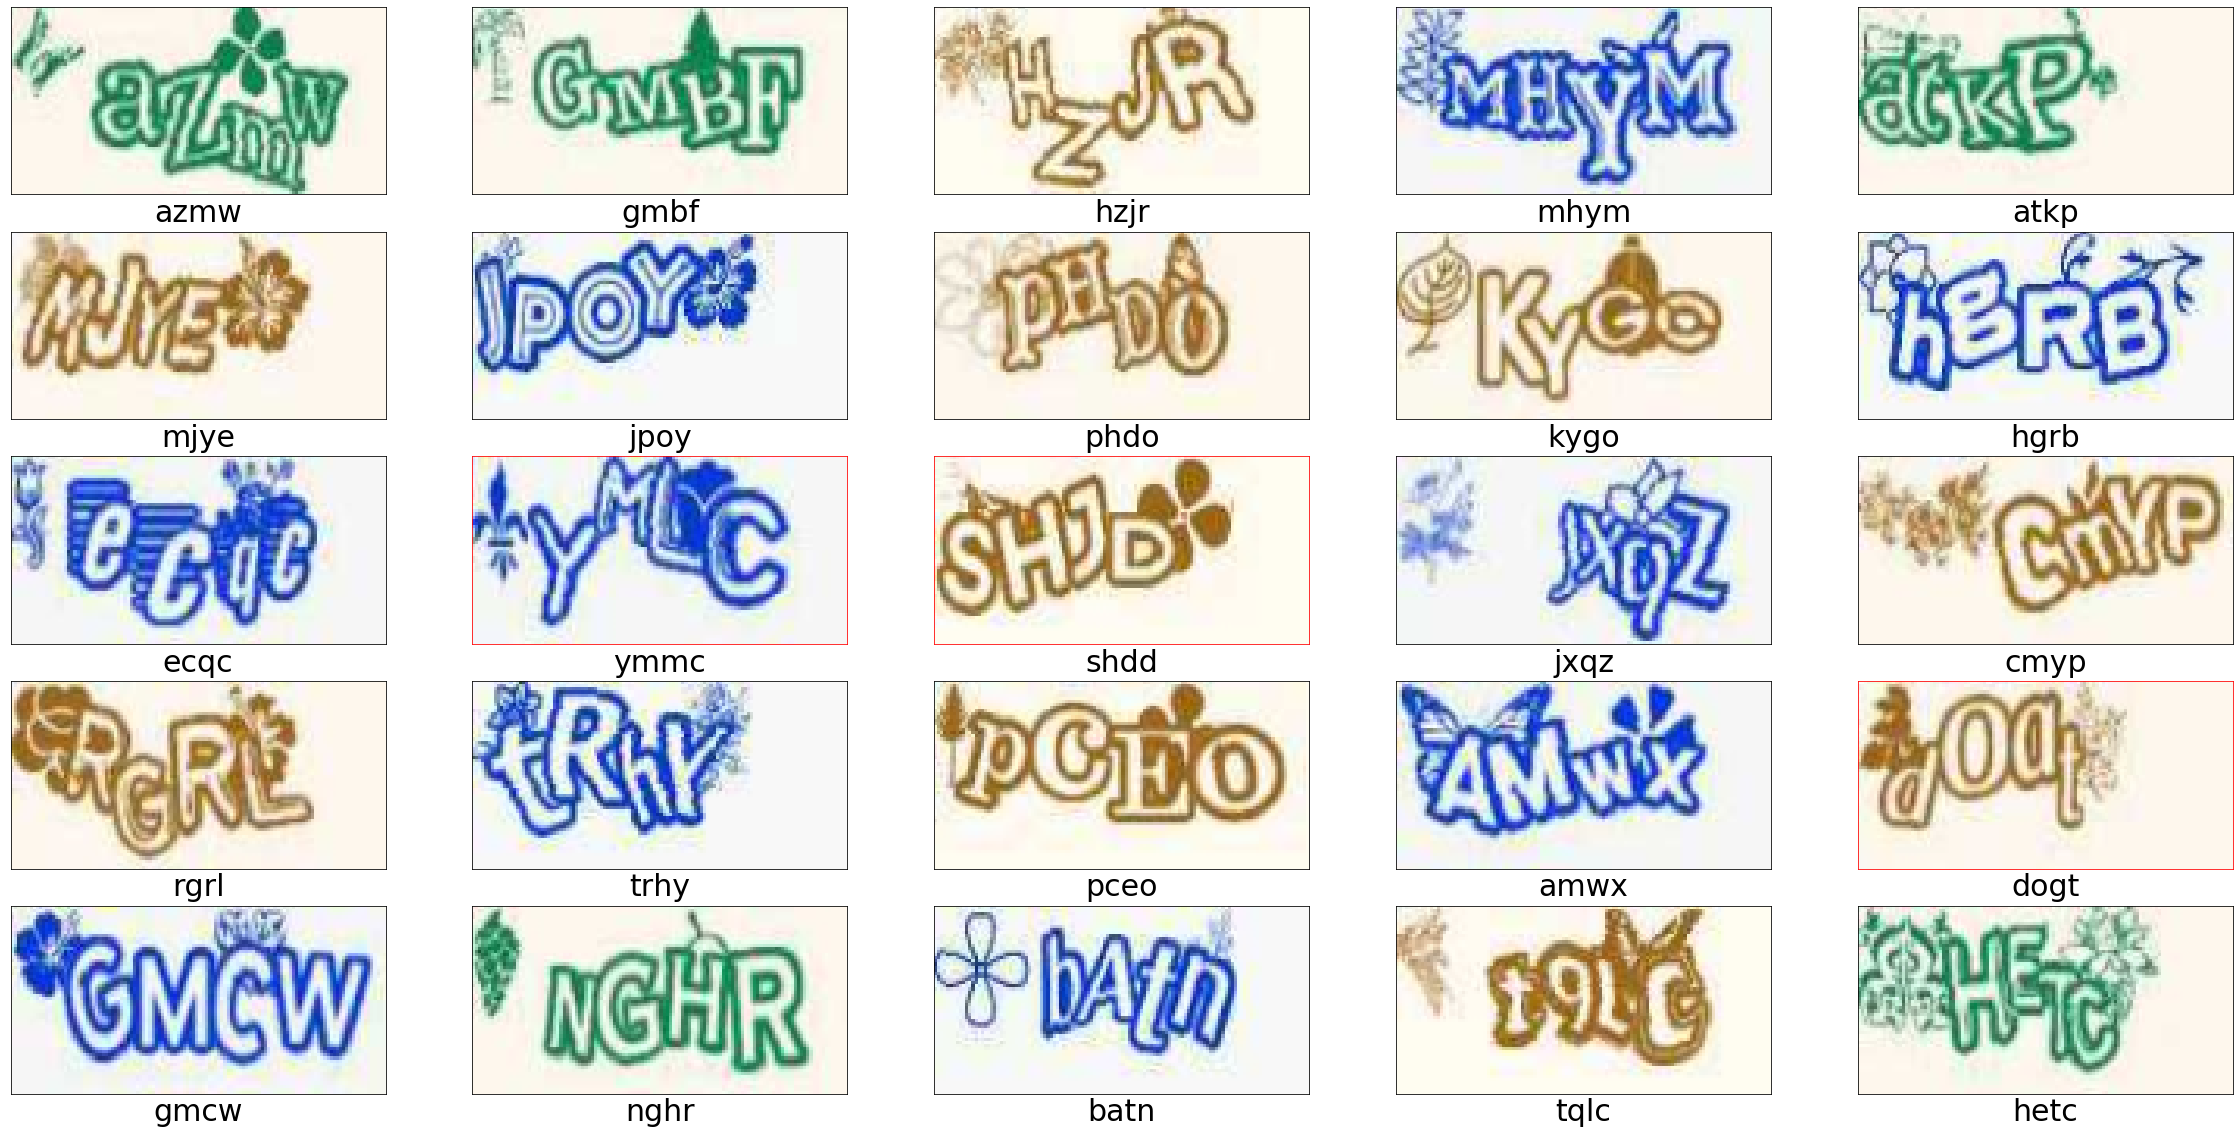

In [28]:
# 4 prediction example
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def decode(tensor):
    '''Decode tensor to label.'''
    codes = tensor.cpu().detach().numpy()
    label = ''
    for i in range(4):
        item = codes[i*26:(i+1)*26]
        idx = np.argmax(item)
        label += chr(ord('a')+idx)
    return label

num = 5
plt.figure(figsize=(40, 20))
for i in range(num**2):
    image, label = train_dataset[i]

    # predict labels
    output = model.predict(image.unsqueeze(0))
    predict_label = decode(output[0])
    
    # real labels
    label = decode(label)

    # plot
    plt.subplot(num, num,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy().transpose(1,2,0))
    plt.xlabel(predict_label, size=30)
    
    # mark error prediction with red border
    if predict_label != label:
        ax = plt.gca()
        for name, border in ax.spines.items():
            border.set_color('red')
plt.show()